In [1]:
# Packages
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
import torch
import os
from typing import Literal, Tuple, Dict, Any
import gc
import matplotlib.pyplot as plt
import psutil
from monitor import ModelMemoryMonitorCPU




In [2]:
# Load Models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Available Device: {device}")
use_amp = amp_supported = torch.cuda.is_available() and torch.cuda.get_device_capability(0) >= (7, 0)
tinyllama_model_name = "TinyLlama/TinyLlama-1.1B-step-50K-105b"
llama7b_model_name = "NousResearch/Llama-2-7b-hf"
# local_model_dir = './model_cache'

# tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-hf")
# model = AutoModelForCausalLM.from_pretrained("NousResearch/Llama-2-7b-hf", torch_dtype=torch.float16).to(device)
# Load model directly

# tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-step-50K-105b")
# model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama-1.1B-step-50K-105b",   torch_dtype=torch.float16).to(device)

Current Available Device: cuda


## Inference: Memory and Max Memory Monitor

In [3]:
# config = AutoConfig.from_pretrained("Tinyllama/Tinyllama-1.1B-step-50K-105b")

# hidden_size = config.hidden_size
# eos_token_id = config.eos_token_id
# max_position_embeddings = config.max_position_embeddings

# print("Hidden Size:", hidden_size)
# print("EOS Token ID:", eos_token_id)
# print("Max Position Embeddings:", max_position_embeddings)

In [4]:
# Hyperparameter
b = 1 # batch size
s = 1 # sequence length
max_s = 4096 # max sequence length

In [5]:

class ModelMemoryUtilities:
    @staticmethod
    def convert_memory(memory: int, memory_unit: Literal['byte', 'mb', 'gb'] = 'byte') -> float:
        """Convert memory to the specified unit."""
        if memory_unit == 'mb':
            return memory / 1048576  # Convert bytes to MB
        elif memory_unit == 'gb':
            return memory / 1073741824  # Convert bytes to GB
        return memory  # Default to bytes

    @staticmethod
    def get_logits(model_output) -> torch.Tensor:
        """Extract logits from model output, supporting various output formats."""
        if hasattr(model_output, 'logits'):
            return model_output.logits
        elif isinstance(model_output, torch.Tensor):
            return model_output
        else:
            raise ValueError("Model output does not contain logits or is not a tensor.")
        
    @staticmethod
    def measure_cpu_memory():
        """Measure CPU memory usage in bytes."""
        return psutil.Process().memory_info().rss

    @staticmethod
    def draw_memory_lines(prev_memory: int, cur_memory_lst: list, peak_memory_lst: list = None, memory_unit: Literal['byte', 'mb', 'gb'] = 'byte'):
        """Plot memory usage over iterations."""
        conv_prev_memory = ModelMemoryUtilities.convert_memory(prev_memory, memory_unit)
        if peak_memory_lst is not None:
            conv_peak_memory = [ModelMemoryUtilities.convert_memory(peak, memory_unit) for peak in peak_memory_lst]
        conv_cur_memory = [ModelMemoryUtilities.convert_memory(cur, memory_unit) for cur in cur_memory_lst]

        plt.figure(figsize=(12, 6))
        iterations = range(len(cur_memory_lst))

        # Baseline memory line
        plt.axhline(y=conv_prev_memory, color='gray', linestyle='--', linewidth=1.5, label=f'Baseline ({conv_prev_memory:.2f} {memory_unit.upper()})')

        # Peak and current memory lines
        if peak_memory_lst is not None:
            plt.plot(iterations, conv_peak_memory, label='Peak Memory', color='#FF5733', linewidth=2.5, linestyle='-', marker='o', markersize=5, alpha=0.85)
        plt.plot(iterations, conv_cur_memory, label='Current Memory', color='#3498DB', linewidth=2.5, linestyle='-', marker='x', markersize=5, alpha=0.85)

        # Labels and title
        plt.xlabel("Iterations", fontsize=12)
        plt.ylabel(f"Memory Usage ({memory_unit.upper()})", fontsize=12)
        plt.title("Memory Usage per Iteration", fontsize=16, fontweight='bold')
        plt.legend()
        plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

        plt.tight_layout()
        plt.show()
        
    @staticmethod
    def draw_memory_from_dict(memory_dict: Dict[str, Any], memory_unit: Literal['byte', 'mb', 'gb'] = 'gb'):
        """
        Draw a memory usage plot with fixed lines for 'model_loading' and 'max_peak_memory', and dynamic lines
        for each stage list found in the dictionary.
        
        :param memory_dict: Dictionary containing memory usage for different stages and fixed values.
        :param memory_unit: The unit for memory display ('byte', 'mb', 'gb').
        """
        
        plt.figure(figsize=(12, 6))

        # Extract and plot fixed lines for 'model_loading' and any 'max_peak_memory'
        fixed_lines = {key: ModelMemoryUtilities.convert_memory(value, memory_unit) for key, value in memory_dict.items()
                       if 'max_peak_memory' in key or key == 'model_loading'}
        for name, value in fixed_lines.items():
            plt.axhline(y=value, linestyle='--', linewidth=1.5, label=f"{name} ({value:.2f} {memory_unit.upper()})")

        # Plot dynamic lines for each memory stage list (e.g., forward_pass, backward_pass, optimize_model)
        dynamic_lines = {key: [ModelMemoryUtilities.convert_memory(val, memory_unit) for val in values] for key, values in memory_dict.items() if isinstance(values, list)}
        iterations = range(len(next(iter(dynamic_lines.values()))))  # Define iterations based on list length

        for stage_name, memory_values in dynamic_lines.items():
            plt.plot(iterations, memory_values, label=f'{stage_name.capitalize()} Memory', marker='o', markersize=5, alpha=0.85)

        # Labels and title
        plt.xlabel("Iterations", fontsize=12)
        plt.ylabel(f"Memory Usage ({memory_unit.upper()})", fontsize=12)
        plt.title("Memory Consumption per Iteration by Stage", fontsize=16, fontweight='bold')
        plt.legend()
        plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
        
        plt.tight_layout()
        plt.show()


In [6]:
class ModelMemoryMonitor:
    def __init__(self, model_name, batch_size=1, max_seq_len=4096, torch_dtype=torch.float16, use_amp=False, device="cuda"):
        """
        Initialize ModelMemoryMonitor for tracking memory usage in inference and training.

        Args:
            model_name (str): Model name or path.
            batch_size (int): Number of samples in a batch.
            max_seq_len (int): Maximum sequence length.
            torch_dtype (torch.dtype): Data type (e.g., torch.float16).
            use_amp (bool): If True, enables mixed precision inference.
            device (str): Device for inference ('cuda' or 'cpu').
        """
        self.model_name = model_name
        self.torch_dtype = torch_dtype
        self.device = device
        self.use_amp = use_amp
        self.batch_size = batch_size
        self.max_seq_len = max_seq_len
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModelForCausalLM.from_pretrained(self.model_name, torch_dtype=self.torch_dtype).to(device)

        # Set pad_token to eos_token if no padding token is available
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

    def simulate_input_ids(self, sequence_length: int, only_padding=False):
        """
        Generate dummy input IDs for a given sequence length.

        Args:
            sequence_length (int): Target sequence length.
            only_padding (bool): If True, generate only padding tokens.

        Returns:
            dict: Input IDs and attention masks.
        """
        dummy_text = "" if only_padding else " ".join(["token"] * int(sequence_length * 1.5))
        inputs = self.tokenizer(dummy_text, return_tensors="pt", padding=True, truncation=True, max_length=self.max_seq_len)
        inputs = {key: value.to(self.device) for key, value in inputs.items()}
        
        actual_length = inputs["input_ids"].shape[1]
        if actual_length != sequence_length:
            print(f"Warning: Expected sequence length ({sequence_length}) does not match actual input length ({actual_length}).")

        attention_mask_sum = inputs["attention_mask"].sum().item()
        if attention_mask_sum != sequence_length:
            print(f"Warning: Attention mask sum ({attention_mask_sum}) does not match expected sequence length ({sequence_length}).")

        return inputs

    def test_cuda_forward_memory(self, sample_inputs, memory_unit: Literal['byte', 'mb', 'gb'] = 'byte') -> Tuple[float, float, float]:
        """
        Measure memory usage during a forward pass.

        Args:
            sample_inputs (dict): Model input data.
            memory_unit (str): Unit for memory display.

        Returns:
            tuple: Previous, peak, and current memory in specified unit.
        """
        self.model.to("cpu")  # Move model to CPU to measure existing memory reliably
        exist_memory = torch.cuda.memory_allocated(self.device)
        self.model.to(self.device)  # Move model back to GPU
        self.model.eval()

        prev_memory = torch.cuda.memory_allocated(self.device)
        torch.cuda.reset_peak_memory_stats()

        with torch.no_grad():
            output = self.model(**sample_inputs)
            output_sum = ModelMemoryUtilities.get_logits(output).sum()
        
        peak_memory = torch.cuda.max_memory_allocated(self.device) - exist_memory
        cur_memory = torch.cuda.memory_allocated(self.device) - exist_memory

        prev_memory = ModelMemoryUtilities.convert_memory(prev_memory - exist_memory, memory_unit)
        peak_memory = ModelMemoryUtilities.convert_memory(peak_memory, memory_unit)
        cur_memory = ModelMemoryUtilities.convert_memory(cur_memory, memory_unit)

        print(f"Previous Memory: {prev_memory:.2f} {memory_unit.upper()}; Peak Memory: {peak_memory:.2f} {memory_unit.upper()}; Current Memory: {cur_memory:.2f} {memory_unit.upper()}")

        return prev_memory, peak_memory, cur_memory
    
    def test_cuda_iterative_inference_memory(self, prompt: str, max_iters: int = 100, memory_unit: Literal['byte', 'mb', 'gb'] = 'byte') -> Tuple[float, list, list]:
        """
        Estimate memory usage during iterative token-by-token generation.

        Args:
            prompt (str): Initial prompt for generation.
            max_iters (int): Maximum number of iterations (tokens) to generate.
            memory_unit (Literal['byte', 'mb', 'gb']): Unit for memory measurement ('byte', 'mb', 'gb').

        Returns:
            Tuple[float, list, list]: Initial memory, list of peak memory per iteration, list of current memory per iteration.
        """
        # Move model to CPU to measure existing memory reliably
        self.model.to("cpu")
        exist_memory = torch.cuda.memory_allocated(self.device)
        self.model.to(self.device)
        self.model.eval()

        # Initial memory state before starting the generation loop
        prev_memory = torch.cuda.memory_allocated(self.device)
        inputs = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=self.max_seq_len)
        input_ids = inputs["input_ids"].to(self.device)
        attention_mask = inputs["attention_mask"].to(self.device)

        # Lists to track memory usage across iterations
        peak_memory_lst, cur_memory_lst = [], []

        for i in range(max_iters):
            torch.cuda.reset_peak_memory_stats()

            with torch.no_grad():
                if self.use_amp:
                    with torch.amp.autocast(device_type=str(self.device)):
                        outputs = self.model.generate(
                            input_ids,
                            attention_mask=attention_mask,
                            max_length=input_ids.shape[1] + 1,
                            eos_token_id=self.tokenizer.eos_token_id,
                            pad_token_id=self.tokenizer.eos_token_id,
                            do_sample=False
                        )
                else:
                    outputs = self.model.generate(
                        input_ids,
                        attention_mask=attention_mask,
                        max_length=input_ids.shape[1] + 1,
                        eos_token_id=self.tokenizer.eos_token_id,
                        pad_token_id=self.tokenizer.eos_token_id,
                        do_sample=False
                    )

                next_token_id = outputs[:, -1:]
                input_ids = torch.cat([input_ids, next_token_id], dim=1)

                # Update attention mask to include the new token
                new_attention_mask = torch.ones((attention_mask.shape[0], 1), dtype=attention_mask.dtype, device=self.device)
                attention_mask = torch.cat([attention_mask, new_attention_mask], dim=1)

                # Stop if EOS token is generated
                if next_token_id.item() == self.tokenizer.eos_token_id:
                    print(f"EOS token generated at iteration {i+1}")
                    break

            # Record peak and current memory usage
            peak_memory_lst.append(torch.cuda.max_memory_allocated(self.device))
            cur_memory_lst.append(torch.cuda.memory_allocated(self.device))

        # Decode generated text
        generated_text = self.tokenizer.decode(input_ids[0], skip_special_tokens=True)
        print(f'Generated Text: {generated_text}')

        # Adjust for pre-existing memory
        prev_memory -= exist_memory
        peak_memory_lst = [peak_memory - exist_memory for peak_memory in peak_memory_lst]
        cur_memory_lst = [cur_memory - exist_memory for cur_memory in cur_memory_lst]

        # Convert memory values to the specified unit
        prev_memory = ModelMemoryUtilities.convert_memory(prev_memory, memory_unit)
        peak_memory_lst = [ModelMemoryUtilities.convert_memory(mem, memory_unit) for mem in peak_memory_lst]
        cur_memory_lst = [ModelMemoryUtilities.convert_memory(mem, memory_unit) for mem in cur_memory_lst]

        return prev_memory, peak_memory_lst, cur_memory_lst

    def test_cuda_training_memory(self, optimizer_type=torch.optim.Adam, max_iters = 1, memory_unit: Literal['byte', 'mb', 'gb'] = 'byte' ):
        device = self.device
        self.model.cpu()
        torch.cuda.reset_peak_memory_stats()
        exist_memory = torch.cuda.memory_allocated(device)
        self.model.to(device)
        self.model.train()
        pre_memory = torch.cuda.memory_allocated(device)

        sample_inputs = self.simulate_input_ids(self.max_seq_len)
        optimizer = optimizer_type(self.model.parameters(), lr=.001)

        optimizer.zero_grad()

        peak_memory_dict = {
            'forward': [],
            'backward': [],
            'optimizer': []
            }

        memory_dict =  {
            'model_loading': None, 
            'forward_pass': [], 
            'backward_pass': [], 
            'optimize_model': []
            }

        for i in range(max_iters):
            if use_amp:
                with torch.amp.autocast(device_type=str(self.device)):
                    output = self.model(**sample_inputs)
                    output_logits = ModelMemoryUtilities.get_logits(output)
                    output_logits_sum = output_logits.sum()
                    forward_memory = torch.cuda.memory_allocated(device)
                    forward_peak_memory = torch.cuda.max_memory_allocated(device)
                    torch.cuda.reset_peak_memory_stats()

                output_logits_sum.backward()
                backward_memory = torch.cuda.memory_allocated(device)
                backward_peak_memory = torch.cuda.max_memory_allocated(device)
                torch.cuda.reset_peak_memory_stats()

                optimizer.step()
                optimizer_memory = torch.cuda.memory_allocated(device)
                optimizer_peak_memory = torch.cuda.max_memory_allocated(device)

            else:
                output = self.model(**sample_inputs).sum()
                output_logits = ModelMemoryUtilities.get_logits(output)
                output_logits_sum = output_logits.sum()
                forward_memory = torch.cuda.memory_allocated(self.device)
                forward_peak_memory = torch.cuda.max_memory_allocated(self.device)
                torch.cuda.reset_peak_memory_stats()

                output_logits_sum.backward()
                backward_memory = torch.cuda.memory_allocated(self.device)
                backward_peak_memory = torch.cuda.max_memory_allocated(self.device)
                torch.cuda.reset_peak_memory_stats()

                optimizer.step()
                optimizer_memory = torch.cuda.memory_allocated(self.device)
                optimizer_peak_memory = torch.cuda.max_memory_allocated(self.device)

            pre_memory -= exist_memory
            forward_memory -= exist_memory
            forward_peak_memory -= exist_memory
            backward_memory -= exist_memory
            backward_peak_memory -= exist_memory
            optimizer_memory -= exist_memory
            optimizer_peak_memory -= exist_memory

            peak_memory_dict['forward'].append(forward_peak_memory)
            peak_memory_dict['backward'].append(backward_peak_memory)
            peak_memory_dict['optimizer'].append(optimizer_peak_memory)

            memory_dict['forward_pass'].append(forward_memory)
            memory_dict['backward_pass'].append(backward_memory)
            memory_dict['optimize_model'].append(optimizer_memory)

        memory_dict['model_loading'] = pre_memory
        filter_peak_memory_dict = {key: max(value) for key, value in peak_memory_dict.items()}
        max_peak_stage, max_peak_memory = max(filter_peak_memory_dict.items(), key=lambda x: x[1])
        memory_dict[f'max_peak_memory({max_peak_stage})'] = max_peak_memory
        
        print(f"The training max peak memory: {ModelMemoryUtilities.convert_memory(max_peak_memory, memory_unit)} ({max_peak_stage} stage)")
        converted_memory_dict = {
            key: [ModelMemoryUtilities.convert_memory(element, memory_unit) for element in value] if isinstance(value, list) else ModelMemoryUtilities.convert_memory(value, memory_unit)
            for key, value in memory_dict.items()
        }
        print(f"the training memory consumption: {converted_memory_dict}")

        return  converted_memory_dict
    
    def test_cpu_forward_memory(self, sample_inputs, memory_unit: Literal['byte', 'mb', 'gb'] = 'byte') -> Tuple[float, float, float]:
        """Estimate memory usage on CPU during a forward pass."""
        self.model.eval()

        prev_memory = ModelMemoryUtilities.measure_cpu_memory()
        
        with torch.no_grad():
            output = self.model(**sample_inputs)

        cur_memory = ModelMemoryUtilities.measure_cpu_memory() 

        prev_memory = ModelMemoryUtilities.convert_memory(prev_memory, memory_unit)
        cur_memory = ModelMemoryUtilities.convert_memory(cur_memory, memory_unit)

        print(f"Previous Memory: {prev_memory:.2f} {memory_unit.upper()}; Current Memory: {cur_memory:.2f} {memory_unit.upper()}")
        
        return prev_memory, cur_memory
    
    def test_cpu_iterative_inference_memory(self, prompt: str, max_iters: int = 100, memory_unit: Literal['byte', 'mb', 'gb'] = 'byte') -> Tuple[float, list, list]:
        """Estimate memory usage on CPU during iterative token-by-token generation."""
        self.model.eval()

        prev_memory = ModelMemoryUtilities.measure_cpu_memory()
        inputs = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=self.max_seq_len)
        input_ids = inputs["input_ids"].to(self.device)
        attention_mask = inputs["attention_mask"].to(self.device)

        cur_memory_lst = []

        for i in range(max_iters):
            with torch.no_grad():
                outputs = self.model.generate(
                    input_ids,
                    attention_mask=attention_mask,
                    max_length=input_ids.shape[1] + 1,
                    eos_token_id=self.tokenizer.eos_token_id,
                    pad_token_id=self.tokenizer.eos_token_id,
                    do_sample=False
                )
                next_token_id = outputs[:, -1:]
                input_ids = torch.cat([input_ids, next_token_id], dim=1)

                # Update attention mask to include the new token
                new_attention_mask = torch.ones((attention_mask.shape[0], 1), dtype=attention_mask.dtype, device=self.device)
                attention_mask = torch.cat([attention_mask, new_attention_mask], dim=1)

                if next_token_id.item() == self.tokenizer.eos_token_id:
                    print(f"EOS token generated at iteration {i+1}")
                    break

            
            cur_memory_lst.append(ModelMemoryUtilities.measure_cpu_memory())

        # Decode generated text
        generated_text = self.tokenizer.decode(input_ids[0], skip_special_tokens=True)
        print(f'Generated Text: {generated_text}')

        cur_memory_lst = [ModelMemoryUtilities.convert_memory(mem, memory_unit) for mem in cur_memory_lst]

        return ModelMemoryUtilities.convert_memory(prev_memory, memory_unit),  cur_memory_lst
    
    def test_cpu_training_memory(self, optimizer_type=torch.optim.Adam, memory_unit: Literal['byte', 'mb', 'gb'] = 'byte') -> Tuple[float, Dict[str, float]]:
        """Estimate memory usage on CPU during a training step (forward, backward, optimizer)."""
        self.model.train()
        prev_memory = ModelMemoryUtilities.measure_cpu_memory()

        sample_inputs = self.simulate_input_ids(self.max_seq_len)
        optimizer = optimizer_type(self.model.parameters(), lr=0.001)
        optimizer.zero_grad()

        forward_memory, backward_memory, optimizer_memory = 0, 0, 0

        output_logits_sum = ModelMemoryUtilities.get_logits(self.model(**sample_inputs)).sum()
        forward_memory = ModelMemoryUtilities.measure_cpu_memory()

        output_logits_sum.backward()
        backward_memory = ModelMemoryUtilities.measure_cpu_memory()

        optimizer.step()
        optimizer_memory = ModelMemoryUtilities.measure_cpu_memory()



        memory_dict = {
            'model_loading': ModelMemoryUtilities.convert_memory(prev_memory, memory_unit),
            'forward_pass': ModelMemoryUtilities.convert_memory(forward_memory, memory_unit),
            'backward_pass': ModelMemoryUtilities.convert_memory(backward_memory, memory_unit),
            'optimize_model': ModelMemoryUtilities.convert_memory(optimizer_memory, memory_unit)
        }

        print(f"Training memory consumption: {memory_dict}")

        return  memory_dict


In [7]:

# class ModelMemoryMonitor:
#     def __init__(self, model_name, batch_size=1, max_seq_len=4096, torch_dtype=torch.float16, use_amp=False, device="cuda"):
#         """
#         Initialize the ModelMemoryMonitor for tracking model inference memory usage.

#         Args:
#             model_name (str): Hugging Face model name or local path.
#             batch_size (int): Number of samples in a batch.
#             max_seq_len (int): Maximum sequence length.
#             torch_dtype (torch.dtype): Data type (e.g., torch.float16).
#             use_amp (bool): If True, enables mixed precision inference.
#             device (str): Device for inference ('cuda' or 'cpu').
#         """
#         self.model_name = model_name
#         self.torch_dtype = torch_dtype
#         self.device = device
#         self.use_amp = use_amp
#         self.batch_size = batch_size
#         self.max_seq_len = max_seq_len
#         self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
#         self.model = AutoModelForCausalLM.from_pretrained(self.model_name, torch_dtype=self.torch_dtype).to(device)

#         # Set pad_token to eos_token if no padding token is available
#         if self.tokenizer.pad_token is None:
#             self.tokenizer.pad_token = self.tokenizer.eos_token

#     def reinitialize_model(self):
#         """Reinitialize the model (useful for testing or resetting)."""
#         self.model = AutoModelForCausalLM.from_pretrained(self.model_name, torch_dtype=self.torch_dtype).to(self.device)

#     def delete_model(self):
#         """Delete the model and clear the GPU cache."""
#         del self.model
#         gc.collect()
#         torch.cuda.empty_cache()
#         print("Model deleted and CUDA cache cleared.")

#     def convert_memory(self, memory, memory_unit: Literal['byte', 'mb', 'gb'] = 'byte'):
#         """Convert memory to specified unit."""
#         if memory_unit == 'mb':
#             return memory / 1048576  # Convert bytes to MB
#         elif memory_unit == 'gb':
#             return memory / 1073741824  # Convert bytes to GB
#         return memory  # Default to bytes
    
#     def get_logits(self, model_output):
#         """
#         Extracts logits from the model output. Supports different output types.

#             Args:
#             model_output: Output from the model's forward pass.

#         Returns:
#             torch.Tensor: The logits tensor.

#         Raises:
#             ValueError: If logits cannot be found in the output.
#         """
#         # Check for `logits` attribute (used by most Hugging Face models)
#         if hasattr(model_output, 'logits'):
#             return model_output.logits
#         # If the output is directly a tensor, assume it's the logits
#         elif isinstance(model_output, torch.Tensor):
#             return model_output
#         else:
#             raise ValueError("Model output does not contain logits or is not a tensor.")


#     def simulate_input_ids(self, sequence_length: int, only_padding=False):
#         """
#         Generate dummy input IDs of specified sequence length.

#         Args:
#             sequence_length (int): Desired sequence length for input IDs.
#             only_padding (bool): If True, generates only padding tokens.

#         Returns:
#             dict: A dictionary with input IDs and attention masks on the specified device.
#         """
#         dummy_text = "" if only_padding else " ".join(["token"] * int(sequence_length * 1.5))
#         inputs = self.tokenizer(dummy_text, return_tensors="pt", padding=True, truncation=True, max_length=self.max_seq_len)
#         inputs = {key: value.to(self.device) for key, value in inputs.items()}

#         # Validate sequence length and attention mask sum
#         actual_length = inputs["input_ids"].shape[1]
#         if actual_length != sequence_length:
#             print(f"Warning: Expected sequence length ({sequence_length}) does not match actual input length ({actual_length}).")

#         attention_mask_sum = inputs["attention_mask"].sum().item()
#         if attention_mask_sum != sequence_length:
#             print(f"Warning: Attention mask sum ({attention_mask_sum}) does not match expected sequence length ({sequence_length}).")

#         return inputs

#     def test_forward_memory(self, sample_inputs, memory_unit: Literal['byte', 'mb', 'gb'] = 'byte'):
#         """
#         Estimate memory usage during a forward pass.

#         Args:
#             sample_inputs (dict): Input data for the model.
#             memory_unit (Literal['byte', 'mb', 'gb']): Unit of memory measurement ('byte', 'mb', 'gb').

#         Returns:
#             tuple: Previous, peak, and current memory in the specified unit.
#         """
#         self.model.cpu()
#         exist_memory = torch.cuda.memory_allocated(self.device)
#         self.model.to(self.device)
#         self.model.eval()

#         # Track initial memory usage
#         prev_memory = torch.cuda.memory_allocated(self.device)
#         torch.cuda.reset_peak_memory_stats()

#         # Perform inference with optional AMP (mixed precision)
#         with torch.no_grad():
#             if self.use_amp:
#                 with torch.amp.autocast(device_type=str(self.device)):
#                     outputs = self.model(**sample_inputs)
#             else:
#                 outputs = self.model(**sample_inputs)

#         # Get peak and current memory usage
#         peak_memory = torch.cuda.max_memory_allocated(self.device)
#         cur_memory = torch.cuda.memory_allocated(self.device)

#         # delete pre-existing memory
#         prev_memory -= exist_memory
#         peak_memory -= exist_memory
#         cur_memory -= exist_memory

#         # Convert memory measurements to the specified unit
#         prev_memory = self.convert_memory(prev_memory, memory_unit)
#         peak_memory = self.convert_memory(peak_memory, memory_unit)
#         cur_memory = self.convert_memory(cur_memory, memory_unit)

#         # Display memory usage summary
#         print(f"Previous Memory: {prev_memory:.2f} {memory_unit.upper()}; Peak Memory: {peak_memory:.2f} {memory_unit.upper()}; Current Memory: {cur_memory:.2f} {memory_unit.upper()}")
#         print(f"Peak Memory Difference: {peak_memory - prev_memory:.2f} {memory_unit.upper()}")
#         print(f"Total Memory Consumption: {cur_memory - prev_memory:.2f} {memory_unit.upper()}")

#         return prev_memory, peak_memory, cur_memory

#     def test_iterative_inference_memory(self, prompt, max_iters=100):
#         """
#         Estimate memory usage during iterative token-by-token generation.

#         Args:
#             prompt (str): Initial prompt for generation.
#             max_iters (int): Maximum number of iterations (tokens) to generate.

#         Returns:
#             tuple: Initial memory, list of peak memory per iteration, list of current memory per iteration.
#         """
#         self.model.cpu()
#         exist_memory = torch.cuda.memory_allocated(self.device)
#         self.model.to(self.device)
#         self.model.eval()
#         prev_memory = torch.cuda.memory_allocated(self.device)
#         inputs = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=self.max_seq_len)
#         input_ids = inputs["input_ids"].to(self.device)
#         attention_mask = inputs["attention_mask"].to(self.device) 

#         peak_memory_lst, cur_memory_lst = [], []

#         for i in range(max_iters):
#             torch.cuda.reset_peak_memory_stats()

#             with torch.no_grad():
#                 if self.use_amp:
#                     with torch.amp.autocast(device_type=str(self.device)):
#                         outputs = self.model.generate(
#                             input_ids,
#                             attention_mask=attention_mask,
#                             max_length=input_ids.shape[1] + 1,
#                             eos_token_id=self.tokenizer.eos_token_id,
#                             pad_token_id=self.tokenizer.eos_token_id,
#                             do_sample=False
#                         )
#                 else:
#                     outputs = self.model.generate(
#                         input_ids,
#                         attention_mask=attention_mask,
#                         max_length=input_ids.shape[1] + 1,
#                         eos_token_id=self.tokenizer.eos_token_id,
#                         pad_token_id=self.tokenizer.eos_token_id,
#                         do_sample=False
#                     )

#                 next_token_id = outputs[:, -1:]
#                 input_ids = torch.cat([input_ids, next_token_id], dim=1)

#                 # Update attention mask to include the new token
#                 new_attention_mask = torch.ones((attention_mask.shape[0], 1), dtype=attention_mask.dtype, device=self.device)
#                 attention_mask = torch.cat([attention_mask, new_attention_mask], dim=1)

#                 if next_token_id.item() == self.tokenizer.eos_token_id:
#                     print(f"EOS token generated at iteration {i+1}")
#                     break

#             peak_memory_lst.append(torch.cuda.max_memory_allocated(self.device))
#             cur_memory_lst.append(torch.cuda.memory_allocated(self.device))

#         generated_text = self.tokenizer.decode(input_ids[0], skip_special_tokens=True)
#         print(f'Generated Text: {generated_text}')

#         # - delete pre-existing memory
#         prev_memory -= exist_memory
#         peak_memory_lst = [peak_memory - exist_memory for peak_memory in peak_memory_lst]
#         cur_memory_lst = [cur_memory - exist_memory for cur_memory in cur_memory_lst]

#         return prev_memory, peak_memory_lst, cur_memory_lst
    
    # def test_training_memory(self, optimizer_type=torch.optim.Adam, memory_unit: Literal['byte', 'mb', 'gb'] = 'byte' ):
    #     device = self.device
    #     self.model.cpu()
    #     torch.cuda.reset_peak_memory_stats()
    #     exist_memory = torch.cuda.memory_allocated(device)
    #     self.model.to(device)
    #     self.model.train()
    #     pre_memory = torch.cuda.memory_allocated(device)

    #     sample_inputs = self.simulate_input_ids(self.max_seq_len)
    #     optimizer = optimizer_type(self.model.parameters(), lr=.001)

    #     optimizer.zero_grad()

    #     if use_amp:
    #         with torch.amp.autocast(device_type=str(self.device)):
    #             output = self.model(**sample_inputs)
    #             output_logits = self.get_logits(output)
    #             output_logits_sum = output_logits.sum()
    #             forward_memory = torch.cuda.memory_allocated(device)
    #             forward_peak_memory = torch.cuda.max_memory_allocated(device)
    #             torch.cuda.reset_peak_memory_stats()

    #         output_logits_sum.backward()
    #         backward_memory = torch.cuda.memory_allocated(device)
    #         backward_peak_memory = torch.cuda.max_memory_allocated(device)
    #         torch.cuda.reset_peak_memory_stats()

    #         optimizer.step()
    #         optimizer_memory = torch.cuda.memory_allocated(device)
    #         optimizer_peak_memory = torch.cuda.max_memory_allocated(device)


    #     else:
    #         # Forward pass without AMP
    #         output = self.model(**sample_inputs).sum()
    #         forward_memory = torch.cuda.memory_allocated(self.device)
    #         forward_peak_memory = torch.cuda.max_memory_allocated(self.device)
    #         torch.cuda.reset_peak_memory_stats()

    #         # Backward pass without AMP
    #         output.backward()
    #         backward_memory = torch.cuda.memory_allocated(self.device)
    #         backward_peak_memory = torch.cuda.max_memory_allocated(self.device)
    #         torch.cuda.reset_peak_memory_stats()

    #         # Optimizer step without AMP
    #         optimizer.step()
    #         optimizer_memory = torch.cuda.memory_allocated(self.device)
    #         optimizer_peak_memory = torch.cuda.max_memory_allocated(self.device)

    #     # - delete existing memory
    #     pre_memory -= exist_memory
    #     forward_memory -= exist_memory
    #     forward_peak_memory -= exist_memory
    #     backward_memory -= exist_memory
    #     backward_peak_memory -= exist_memory
    #     optimizer_memory -= exist_memory
    #     optimizer_peak_memory -= exist_memory

    #     peak_memory_dict = {
    #         'forward': forward_peak_memory,
    #         'backward': backward_peak_memory,
    #         'optimizer': optimizer_peak_memory
    #     }

        
    #     max_peak_stage, max_peak_memory = max(peak_memory_dict.items(), key=lambda x: x[1])
        
    #     memory_dict = {'model_loading': pre_memory, 'forward_pass': forward_memory, 'backward_pass': backward_memory, 'optimize_model': optimizer_memory }

    #     print(f"The training max peak memory: {self.convert_memory(max_peak_memory, memory_unit)} ({max_peak_stage} stage)")
    #     converted_memory_dict = {key: self.convert_memory(value, memory_unit) for key, value in memory_dict.items()}
    #     print(f"the training memory consumption: {converted_memory_dict}")

    #     return max_peak_memory, memory_dict


#     def draw_memory_lines(self, prev_memory, peak_memory_lst, cur_memory_lst, memory_unit: Literal['byte', 'mb', 'gb'] = 'byte'):
#         """
#         Plot memory usage over iterations.

#         Args:
#             prev_memory (int): Baseline memory usage.
#             peak_memory_lst (list[int]): List of peak memory usage per iteration.
#             cur_memory_lst (list[int]): List of current memory usage per iteration.
#             memory_unit (Literal['byte', 'mb', 'gb']): Unit for memory measurements ('byte', 'mb', 'gb').
#         """
#         conv_prev_memory = self.convert_memory(prev_memory, memory_unit)
#         conv_peak_memory = [self.convert_memory(peak, memory_unit) for peak in peak_memory_lst]
#         conv_cur_memory = [self.convert_memory(cur, memory_unit) for cur in cur_memory_lst]

#         plt.figure(figsize=(12, 6))
#         iterations = range(len(peak_memory_lst))

#         # Baseline memory line
#         plt.axhline(y=conv_prev_memory, color='gray', linestyle='--', linewidth=1.5, label=f'Baseline ({conv_prev_memory:.2f} {memory_unit.upper()})')

#         # Peak and current memory lines
#         plt.plot(iterations, conv_peak_memory, label='Peak Memory', color='#FF5733', linewidth=2.5, linestyle='-', marker='o', markersize=5, alpha=0.85)
#         plt.plot(iterations, conv_cur_memory, label='Current Memory', color='#3498DB', linewidth=2.5, linestyle='-', marker='x', markersize=5, alpha=0.85)

#         # Labels and title
#         plt.xlabel("Iterations", fontsize=12)
#         plt.ylabel(f"Memory Usage ({memory_unit.upper()})", fontsize=12)
#         plt.title("Memory Usage per Iteration", fontsize=16, fontweight='bold')
#         plt.legend()
#         plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

#         plt.tight_layout()
#         plt.show()

In [8]:
# # - Test estimate forward memory method
# monitor = ModelMemoryMonitor(llama7b_model_name, use_amp=use_amp, device=device)
# sample_inputs = monitor.simulate_input_ids(1)
# monitor.test_cuda_forward_memory(sample_inputs, memory_unit='mb')

In [9]:
# # Test estimate inference memory method
# prompt = (
#     'You should generate 100 words to explain diffusion model: '
# )
# monitor = ModelMemoryMonitor(llama7b_model_name, use_amp=use_amp, device=device)
# prev_memory, peak_memory_lst, cur_memory_lst = monitor.test_cuda_iterative_inference_memory(prompt)
# ModelMemoryUtilities.draw_memory_lines(prev_memory, cur_memory_lst, peak_memory_lst, memory_unit='gb')

In [10]:
# # Test test training memory method
# monitor = ModelMemoryMonitor(tinyllama_model_name, use_amp=use_amp, device=device)
# memory_dict = monitor.test_cuda_training_memory(max_iters=10)
# ModelMemoryUtilities.draw_memory_from_dict(memory_dict, memory_unit='gb')

In [11]:
# - Start to CPU test
device = torch.device('cpu')

In [12]:
# # Test cpu test forward memory method
# monitor = ModelMemoryMonitorCPU(tinyllama_model_name, device=device)
# sample_inputs = monitor.simulate_input_ids(1)
# monitor.test_cpu_forward_memory(sample_inputs, memory_unit='gb')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/yuz165/LLM-Simulator/llm-simulator-env/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/yuz165/LLM-Simulator/llm-simulator-env/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


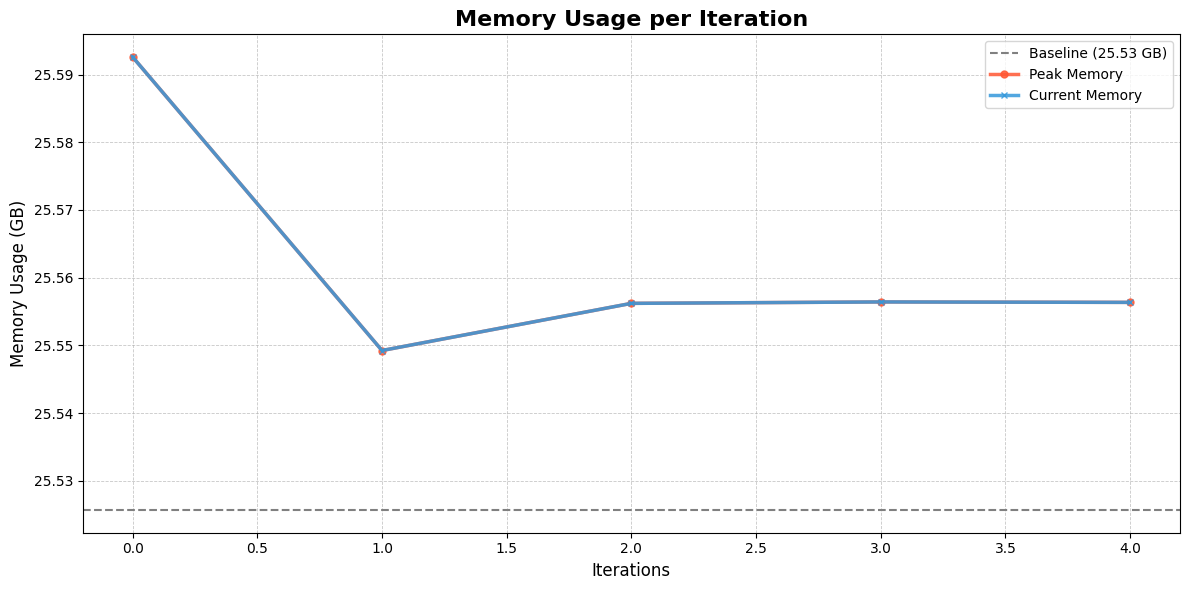

In [13]:
# Test cpu inference memory method
prompt = (
    'You should generate 100 words to explain diffusion model: '
)
monitor = ModelMemoryMonitorCPU(llama7b_model_name, device=device)
prev_memory, peak_memory_lst, cur_memory_lst = monitor.test_cpu_iterative_inference_memory(prompt, max_iters= 5)

ModelMemoryUtilities.draw_memory_lines(prev_memory, cur_memory_lst, peak_memory_lst=peak_memory_lst, memory_unit='gb')

In [14]:
# Test test training memory method
monitor = ModelMemoryMonitorCPU(tinyllama_model_name, device=device)
memory_dict = monitor.test_cpu_training_memory(max_iters=3)

the training memory consumption: {'model_loading': 523497472, 'forward_pass': [21614276608, 31245496320, 31491342336], 'backward_pass': [10369863680, 20088070144, 19863822336], 'optimize_model': [19253780480, 20088221696, 19864543232], 'max_peak_memory(forward)': 31491342336}


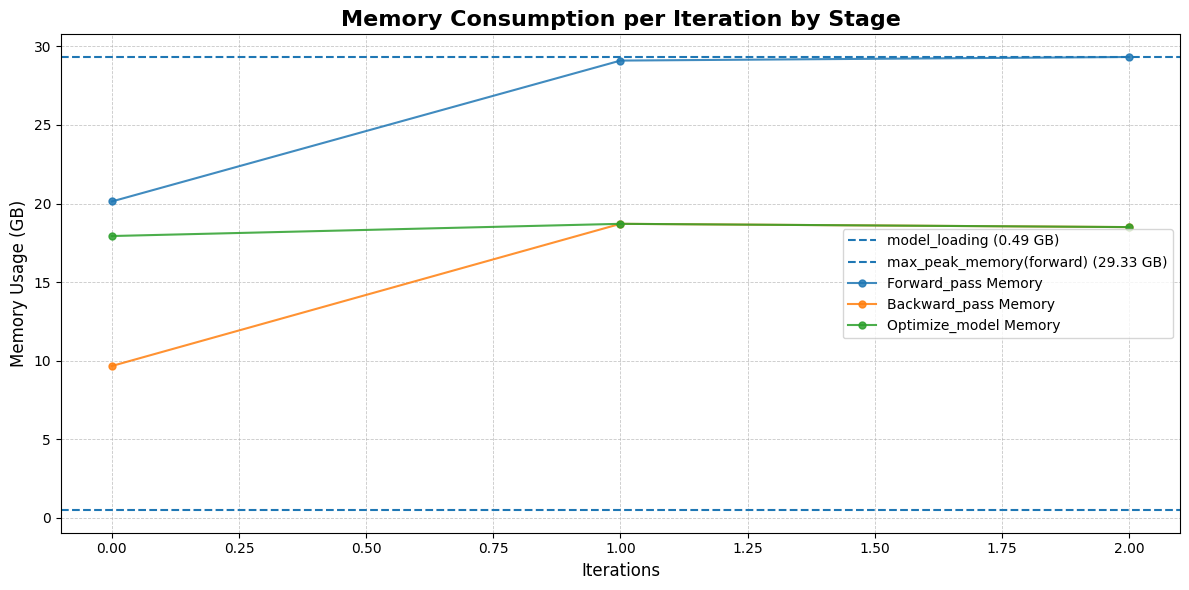

In [15]:

ModelMemoryUtilities.draw_memory_from_dict(memory_dict, memory_unit='gb')

In [16]:
memory_dict

{'model_loading': 523497472,
 'forward_pass': [21614276608, 31245496320, 31491342336],
 'backward_pass': [10369863680, 20088070144, 19863822336],
 'optimize_model': [19253780480, 20088221696, 19864543232],
 'max_peak_memory(forward)': 31491342336}